In [11]:
"""Uncertainty bound on 1st order unstable system.

James Richard Forbes, 2023/10/07
Modified by Aidan Kimberley, 2025/10/27

Plant example from Mathworks ucover example,
https://www.mathworks.com/help/robust/ref/dynamicsystem.ucover.html
"""
# %%
# Libraries
import numpy as np
from matplotlib import pyplot as plt
import control
# import pathlib

# Custom libraries
import unc_bound

In [12]:
# %%

# Plotting parameters
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')
# path = pathlib.Path('figs')
# path.mkdir(exist_ok=True)

/Users/aidan1/Documents/McGill/MECH412/control_env/lib/python3.14/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


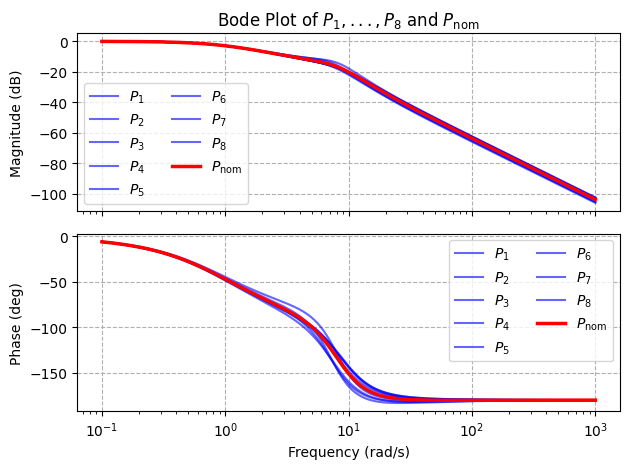

In [13]:
# %%

# Create uncertain transfer functions

# Laplace variable s
s = control.tf('s')

# Third order TF from the image
# Coefficients for each plant
num_coeffs = [
    [74.47/10.1, 74.47],
    [77.64/10.5, 77.64],
    [52.62/9.5, 52.62],
    [77.91/11.0, 77.91],
    [68.31/10.3, 68.31],
    [51.77/9.6, 51.77],
    [57.11/11.3, 57.11],
    [65.51/8.6, 65.51]
]
den_coeffs = [
    [1, 11.21, 84.68, 74.47],
    [1, 11.45, 88.09, 77.64],
    [1, 7.261, 58.88, 52.62],
    [1, 11.49, 88.40, 77.91],
    [1, 10.78, 78.08, 68.31],
    [1, 8.153, 58.92, 51.77],
    [1, 9.465, 65.57, 57.11],
    [1, 7.934, 72.44, 65.51]
]

num_avg = np.mean(num_coeffs, axis=0)
den_avg = np.mean(den_coeffs, axis=0)

P_nominal = control.tf(num_avg, den_avg)

# Assign each plant instance as before for "off-nominal" plants
P1 = 74.47 * (s/10.1 + 1) / (s**3 + 11.21*s**2 + 84.68*s + 74.47)
P2 = 77.64 * (s/10.5 + 1) / (s**3 + 11.45*s**2 + 88.09*s + 77.64)
P3 = 52.62 * (s/9.5 + 1) / (s**3 + 7.261*s**2 + 58.88*s + 52.62)
P4 = 77.91 * (s/11.0 + 1) / (s**3 + 11.49*s**2 + 88.40*s + 77.91)
P5 = 68.31 * (s/10.3 + 1) / (s**3 + 10.78*s**2 + 78.08*s + 68.31)
P6 = 51.77 * (s/9.6 + 1) / (s**3 + 8.153*s**2 + 58.92*s + 51.77)
P7 = 57.11 * (s/11.3 + 1) / (s**3 + 9.465*s**2 + 65.57*s + 57.11)
P8 = 65.51 * (s/8.6 + 1) / (s**3 + 7.934*s**2 + 72.44*s + 65.51)

P_nom = P_nominal  # for clarity, just an alias

P_list = [P1, P2, P3, P4, P5, P6, P7, P8]
labels = [f'$P_{{{i}}}$' for i in range(1, 9)]
colors = [f'C{i}' for i in range(8)]

# Frequency vector (safe coverage)
w_bode = np.logspace(-1, 3, 500)

# Make Bode plot
fig, ax = plt.subplots(2, 1, sharex=True)
for i, P_sys in enumerate(P_list):
    mag, phase, w = control.bode(P_sys, w_bode, plot=False)
    ax[0].semilogx(w, 20*np.log10(mag), color='blue', alpha=0.6, linewidth=1.5, label=labels[i])
    ax[1].semilogx(w, phase * 180/np.pi, color='blue', alpha=0.6, linewidth=1.5, label=labels[i])

# Plot P_nominal
mag_nom, phase_nom, w_nom = control.bode(P_nom, w_bode, plot=False)
ax[0].semilogx(w_nom, 20*np.log10(mag_nom), linestyle='-', color='red', linewidth=2.5, label='$P_{\\mathrm{nom}}$')
ax[1].semilogx(w_nom, phase_nom * 180/np.pi, linestyle='-', color='red', linewidth=2.5, label='$P_{\\mathrm{nom}}$')

ax[0].set_ylabel('Magnitude (dB)')
ax[1].set_ylabel('Phase (deg)')
ax[1].set_xlabel('Frequency (rad/s)')
ax[0].legend(loc='best', ncol=2)
ax[1].legend(loc='best', ncol=2)
ax[0].set_title('Bode Plot of $P_1, ..., P_8$ and $P_{\\mathrm{nom}}$')

plt.tight_layout()
plt.show()

# Use P1 as the nominal plant (matches original comment)
P = P_nominal

# Uncertain plants as a list
P_off_nom = P_list
N = len(P_off_nom)

a) I chose the nominal plant by taking the average of the coefficient of the off nominal plants. This effectively captured the average behaivor of all transfer functions as you can see in this bode plot where the red nomai l plant line sits in between the off nominal plants.

In [14]:
# %%

# Compute residuals
R_multiplicative = unc_bound.residuals(P, P_off_nom, method='multiplicative')
R_additive = unc_bound.residuals(P, P_off_nom, method='additive')
R_inverse_additive = unc_bound.residuals(P, P_off_nom, method='inverse additive')
R_inverse_multiplicative = unc_bound.residuals(P, P_off_nom, method='inverse multiplicative')
# Bode plot
N_w = 500
w_shared = np.logspace(-1, 3, N_w)

# Compute magnitude part of R(s) in both dB and in absolute units
mag_max_dB_multiplicative, mag_max_abs_multiplicative = unc_bound.residual_max_mag(R_multiplicative, w_shared)
mag_max_dB_additive, mag_max_abs_additive = unc_bound.residual_max_mag(R_additive, w_shared)
mag_max_dB_inverse_additive, mag_max_abs_inverse_additive = unc_bound.residual_max_mag(R_inverse_additive, w_shared)
mag_max_dB_inverse_multiplicative, mag_max_abs_inverse_multiplicative = unc_bound.residual_max_mag(R_inverse_multiplicative, w_shared)

# Note: Initial residual plots removed - will plot with optimal bounds later

I made edits to the unc_bound.residuals function to include the different residual types.

In [15]:
# %%

# Find W2

# Order of W2
nW2 = 4
nW2_inverse_additive = 4  # Higher order for inverse additive due to more complex behavior

# Calculate optimal upper bound transfer function.
W2_multiplicative = (unc_bound.upperbound(omega=w_shared, upper_bound=mag_max_abs_multiplicative, degree=nW2)).minreal()
W2_additive = (unc_bound.upperbound(omega=w_shared, upper_bound=mag_max_abs_additive, degree=nW2)).minreal()
W2_inverse_additive = (unc_bound.upperbound(omega=w_shared, upper_bound=mag_max_abs_inverse_additive, degree=nW2_inverse_additive)).minreal()
W2_inverse_multiplicative = (unc_bound.upperbound(omega=w_shared, upper_bound=mag_max_abs_inverse_multiplicative, degree=nW2)).minreal()
print("\n" + "="*60)
print("=== MULTIPLICATIVE UNCERTAINTY ===")
print("="*60)
print("Maximum uncertainty magnitude: {:.4f} ({:.2f} dB)".format(
    np.max(mag_max_abs_multiplicative), 
    20*np.log10(np.max(mag_max_abs_multiplicative))))
print("The optimal weighting function W_2(s) is:\n", W2_multiplicative)

print("\n" + "="*60)
print("=== ADDITIVE UNCERTAINTY ===")
print("="*60)
print("Maximum uncertainty magnitude: {:.4f} ({:.2f} dB)".format(
    np.max(mag_max_abs_additive), 
    20*np.log10(np.max(mag_max_abs_additive))))
print("The optimal weighting function W_2(s) is:\n", W2_additive)

print("\n" + "="*60)
print("=== INVERSE ADDITIVE UNCERTAINTY ===")
print("="*60)
print("Maximum uncertainty magnitude: {:.4e} ({:.2f} dB)".format(
    np.max(mag_max_abs_inverse_additive), 
    20*np.log10(np.max(mag_max_abs_inverse_additive))))
print("The optimal weighting function W_2(s) is:\n", W2_inverse_additive)

print("\n" + "="*60)
print("=== INVERSE MULTIPLICATIVE UNCERTAINTY ===")
print("="*60)
print("Maximum uncertainty magnitude: {:.4f} ({:.2f} dB)".format(
    np.max(mag_max_abs_inverse_multiplicative), 
    20*np.log10(np.max(mag_max_abs_inverse_multiplicative))))
print("The optimal weighting function W_2(s) is:\n", W2_inverse_multiplicative)
print("="*60)


=== MULTIPLICATIVE UNCERTAINTY ===
Maximum uncertainty magnitude: 0.3550 (-9.00 dB)
The optimal weighting function W_2(s) is:
 <TransferFunction>: sys[678]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.2237 s^4 + 2.265 s^3 + 10.63 s^2 + 44.83 s + 2.322
  ----------------------------------------------------
      s^4 + 9.009 s^3 + 83.98 s^2 + 286.9 s + 1014

=== ADDITIVE UNCERTAINTY ===
Maximum uncertainty magnitude: 0.0632 (-23.99 dB)
The optimal weighting function W_2(s) is:
 <TransferFunction>: sys[681]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  1.802e-05 s^4 + 0.5857 s^3 + 1.045 s^2 + 0.9217 s + 0.02869
  -----------------------------------------------------------
          s^4 + 10.08 s^3 + 33.15 s^2 + 39 s + 14.96

=== INVERSE ADDITIVE UNCERTAINTY ===
Maximum uncertainty magnitude: 4.4266e+04 (92.92 dB)
The optimal weighting function W_2(s) is:
 <TransferFunction>: sys[684]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

                4.427e+04
  ------------------------------

I used a fourth order uncertainty bound (W) for all models.

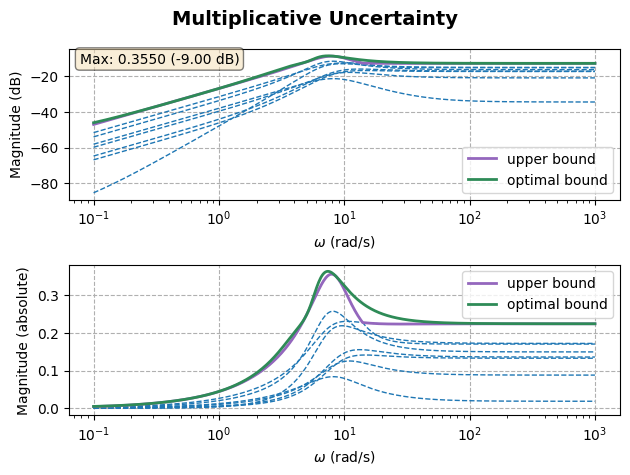

In [16]:
# %%

# Plot the Bode magnitude plot of the optimal W_2(s) transfer function

# Compute magnitude part of W_2(s) in absolute units
mag_W2_abs_multiplicative, _, _ = control.frequency_response(W2_multiplicative, w_shared)
mag_W2_abs_additive, _, _ = control.frequency_response(W2_additive, w_shared)
mag_W2_abs_inverse_additive, _, _ = control.frequency_response(W2_inverse_additive, w_shared)
mag_W2_abs_inverse_multiplicative, _, _ = control.frequency_response(W2_inverse_multiplicative, w_shared)
# Compute magnitude part of W_2(s) in dB
mag_W2_dB_multiplicative = 20 * np.log10(mag_W2_abs_multiplicative)
mag_W2_dB_additive = 20 * np.log10(mag_W2_abs_additive)
mag_W2_dB_inverse_additive = 20 * np.log10(mag_W2_abs_inverse_additive)
mag_W2_dB_inverse_multiplicative = 20 * np.log10(mag_W2_abs_inverse_multiplicative)

# Plot 1: Multiplicative Uncertainty
fig1, ax1 = plt.subplots(2, 1)
fig1.suptitle('Multiplicative Uncertainty', fontsize=14, fontweight='bold')
ax1[0].set_xlabel(r'$\omega$ (rad/s)')
ax1[0].set_ylabel(r'Magnitude (dB)')
ax1[1].set_xlabel(r'$\omega$ (rad/s)')
ax1[1].set_ylabel(r'Magnitude (absolute)')
for i in range(N):
    mag_abs, _, _ = control.frequency_response(R_multiplicative[i], w_shared)
    mag_dB = 20 * np.log10(mag_abs)
    ax1[0].semilogx(w_shared, mag_dB, '--', color='C0', linewidth=1)
    ax1[1].semilogx(w_shared, mag_abs, '--', color='C0', linewidth=1)
ax1[0].semilogx(w_shared, mag_max_dB_multiplicative, '-', color='C4', label='upper bound', linewidth=2)
ax1[1].semilogx(w_shared, mag_max_abs_multiplicative, '-', color='C4', label='upper bound', linewidth=2)
ax1[0].semilogx(w_shared, mag_W2_dB_multiplicative, '-', color='seagreen', label='optimal bound', linewidth=2)
ax1[1].semilogx(w_shared, mag_W2_abs_multiplicative, '-', color='seagreen', label='optimal bound', linewidth=2)
# Add max magnitude text
max_mag = np.max(mag_max_abs_multiplicative)
ax1[0].text(0.02, 0.98, f'Max: {max_mag:.4f} ({20*np.log10(max_mag):.2f} dB)', 
            transform=ax1[0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax1[0].legend(loc='best')
ax1[1].legend(loc='best')
fig1.tight_layout()
plt.show()

b ii) The multiplicative uncertainty model has relatively low magnitude, effectively captures high frequency error, and optimal bound holds reletively tight to the upper residual bound.

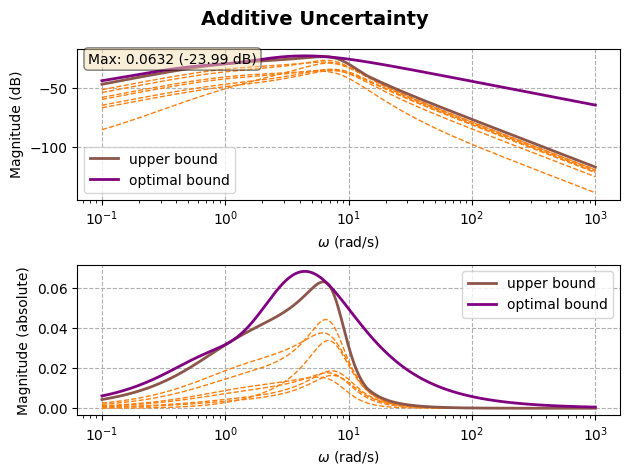

In [17]:
#%%

# Plot 2: Additive Uncertainty
fig2, ax2 = plt.subplots(2, 1)
fig2.suptitle('Additive Uncertainty', fontsize=14, fontweight='bold')
ax2[0].set_xlabel(r'$\omega$ (rad/s)')
ax2[0].set_ylabel(r'Magnitude (dB)')
ax2[1].set_xlabel(r'$\omega$ (rad/s)')
ax2[1].set_ylabel(r'Magnitude (absolute)')
for i in range(N):
    mag_abs, _, _ = control.frequency_response(R_additive[i], w_shared)
    mag_dB = 20 * np.log10(mag_abs)
    ax2[0].semilogx(w_shared, mag_dB, '--', color='C1', linewidth=1)
    ax2[1].semilogx(w_shared, mag_abs, '--', color='C1', linewidth=1)
ax2[0].semilogx(w_shared, mag_max_dB_additive, '-', color='C5', label='upper bound', linewidth=2)
ax2[1].semilogx(w_shared, mag_max_abs_additive, '-', color='C5', label='upper bound', linewidth=2)
ax2[0].semilogx(w_shared, mag_W2_dB_additive, '-', color='purple', label='optimal bound', linewidth=2)
ax2[1].semilogx(w_shared, mag_W2_abs_additive, '-', color='purple', label='optimal bound', linewidth=2)
# Add max magnitude text
max_mag = np.max(mag_max_abs_additive)
ax2[0].text(0.02, 0.98, f'Max: {max_mag:.4f} ({20*np.log10(max_mag):.2f} dB)', 
            transform=ax2[0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax2[0].legend(loc='best')
ax2[1].legend(loc='best')
fig2.tight_layout()
plt.show()

b i) The additive uncertainty model has really low uncertainty, a max uncertainty of -24dB, however it fails to capture high frequency uncertainty which is always present in models. Also the optimal bound does not hold very tight to the upper bound.

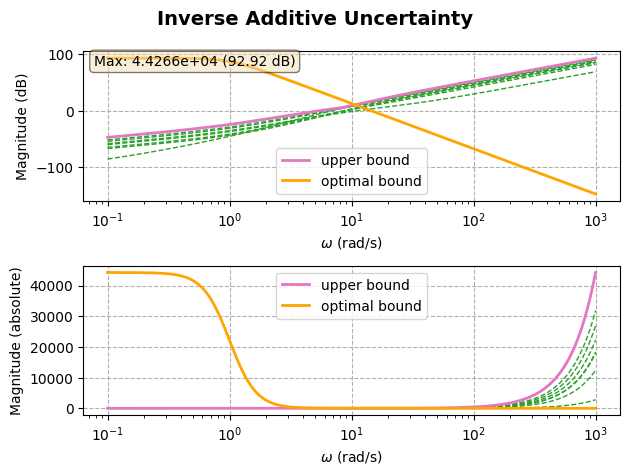

In [18]:
#%%

# Plot 3: Inverse Additive Uncertainty
fig3, ax3 = plt.subplots(2, 1)
fig3.suptitle('Inverse Additive Uncertainty', fontsize=14, fontweight='bold')
ax3[0].set_xlabel(r'$\omega$ (rad/s)')
ax3[0].set_ylabel(r'Magnitude (dB)')
ax3[1].set_xlabel(r'$\omega$ (rad/s)')
ax3[1].set_ylabel(r'Magnitude (absolute)')
for i in range(N):
    mag_abs, _, _ = control.frequency_response(R_inverse_additive[i], w_shared)
    mag_dB = 20 * np.log10(mag_abs)
    ax3[0].semilogx(w_shared, mag_dB, '--', color='C2', linewidth=1)
    ax3[1].semilogx(w_shared, mag_abs, '--', color='C2', linewidth=1)
ax3[0].semilogx(w_shared, mag_max_dB_inverse_additive, '-', color='C6', label='upper bound', linewidth=2)
ax3[1].semilogx(w_shared, mag_max_abs_inverse_additive, '-', color='C6', label='upper bound', linewidth=2)
ax3[0].semilogx(w_shared, mag_W2_dB_inverse_additive, '-', color='orange', label='optimal bound', linewidth=2)
ax3[1].semilogx(w_shared, mag_W2_abs_inverse_additive, '-', color='orange', label='optimal bound', linewidth=2)
# Add max magnitude text
max_mag = np.max(mag_max_abs_inverse_additive)
ax3[0].text(0.02, 0.98, f'Max: {max_mag:.4e} ({20*np.log10(max_mag):.2f} dB)', 
            transform=ax3[0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax3[0].legend(loc='best')
ax3[1].legend(loc='best')
fig3.tight_layout()
plt.show()

biii) The 4th order optimal bound completely failed to capture the dynamics of the upper bound of the residuals. The inverse additive residuals were far too complex to be captured by a 4th order bound. The uncertainty itself is also extremely high with this model

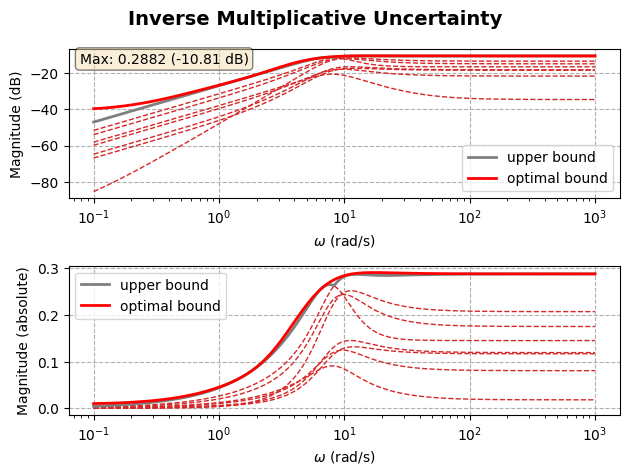

In [19]:
#%%

# Plot 4: Inverse Multiplicative Uncertainty
fig4, ax4 = plt.subplots(2, 1)
fig4.suptitle('Inverse Multiplicative Uncertainty', fontsize=14, fontweight='bold')
ax4[0].set_xlabel(r'$\omega$ (rad/s)')
ax4[0].set_ylabel(r'Magnitude (dB)')
ax4[1].set_xlabel(r'$\omega$ (rad/s)')
ax4[1].set_ylabel(r'Magnitude (absolute)')
for i in range(N):
    mag_abs, _, _ = control.frequency_response(R_inverse_multiplicative[i], w_shared)
    mag_dB = 20 * np.log10(mag_abs)
    ax4[0].semilogx(w_shared, mag_dB, '--', color='C3', linewidth=1)
    ax4[1].semilogx(w_shared, mag_abs, '--', color='C3', linewidth=1)
ax4[0].semilogx(w_shared, mag_max_dB_inverse_multiplicative, '-', color='C7', label='upper bound', linewidth=2)
ax4[1].semilogx(w_shared, mag_max_abs_inverse_multiplicative, '-', color='C7', label='upper bound', linewidth=2)
ax4[0].semilogx(w_shared, mag_W2_dB_inverse_multiplicative, '-', color='red', label='optimal bound', linewidth=2)
ax4[1].semilogx(w_shared, mag_W2_abs_inverse_multiplicative, '-', color='red', label='optimal bound', linewidth=2)
# Add max magnitude text
max_mag = np.max(mag_max_abs_inverse_multiplicative)
ax4[0].text(0.02, 0.98, f'Max: {max_mag:.4f} ({20*np.log10(max_mag):.2f} dB)', 
            transform=ax4[0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax4[0].legend(loc='best')
ax4[1].legend(loc='best')
fig4.tight_layout()
plt.show()

b iv) The Inverse multiplicative uncertainty model has a low max uncertainty, -10.81 dB, effectively captures high frequency error, and the optimal bound very closely bounds the residuals.

In [20]:
# %%

# Plot
plt.show()